In [1]:
import sys
print("python version: ", sys.version)

import pandas as pd
print("pandas version: ", pd.__version__)

import numpy as np
print('numpy version: ', np.__version__)

import scipy as sp
print('scipy version: ', sp.__version__)

import sklearn as skl
print('sklearn version: ', skl.__version__)

import matplotlib.pyplot as plt

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import keras as ks
print('keras version: ', ks.__version__)
print('keras backend: ', ks.backend.backend())

import tensorflow as tf
print('tensorflow version: ', tf.__version__)

import warnings
warnings.filterwarnings('ignore')

from keras import backend as K
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, precision_recall_curve

import random

python version:  3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
pandas version:  0.24.2
numpy version:  1.16.4
scipy version:  1.3.0
sklearn version:  0.21.2


Using TensorFlow backend.


keras version:  2.2.4
keras backend:  tensorflow
tensorflow version:  1.14.0


In [2]:
excel_file = r'geriomop-data-from-egems-paper-UPDATED-COL-FIX-ATC_2-and-behavior-change-022819.tsv'
df = pd.DataFrame(pd.read_csv(excel_file, sep='\t'))
print(df.shape)

(7584, 208)


In [3]:
# Drop features
f_drop = ["Blank-1", "ws-sudden-stop", "ws-sudden-stop-drugs", "ws-prolonged-psychotropics", "mds-toilet-prgm-atmptd"] + \
         ['Deleted-%d' % i for i in range(1, 13)] + ['Psychotropic-%d' % i for i in range(1, 6)] + \
         ['Psychotropic-%d-average-daily-dose' % i for i in range(1, 6)] + ["Entry-discharge-type"]

# Missing value means not relevant
f_one_hot = ["Mds-fall-2-6-months-to-admission", "Mds-fall-last-month-to-admission", "mds-pain-last-five-days", \
             "mds-delirium-scale", "mds-long-term-memory-ok", "mds-short-term-memory-ok", "mds-staff-assess-pain", \
             "recent-start-other-fall-risk-rx"] + ["mds-pressure-ulcer-stage-%d" % i for i in range(1, 5)]
cate_one_hot = [['Yes', 'No', 'Unable to answer']] * 3 + [['Yes', 'No']] * 9

f_period = [("Psychotropic-%d-Start-date" % i, 'Psychotropic-%d-End-date' % i, 'Psychotropic-%d-Period' % i) for i in range(1, 6)]

f_label = ['mds-cognitive-scale', 'mds-pain-freq-last-five-days', 'mds-pain-intensity']
dic_label = [{'Independent': 0, 'Modified Independence': 1, 'Moderately Impaired': 2, 'Severely Impaired': 3}, \
             {'Continuous': 4, 'Frequent': 3, 'Occasional': 2, 'Rare': 1, 'Unable to respond': 0}, \
             {'None': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3, 'Very severe, horrible': 4}]

f_transform = [('mds-cognitive-scale', 3, 0), ('mds-pain-freq-last-five-days', 4, 0), ('mds-pain-intensity', 4, 0)] + \
              [('Psychotropic-%d-Period' % i, 0, 0) for i in range(1, 6)]

In [4]:
# Encode features (originally) with no missing values
f_drop += ["predictor-date", "projected-date", "PPS-assessment", "Federal-assessment"]

f_period += [('episode-start-date', 'episode-end-date', 'episode-period'),\
             ('stay-start-date', 'stay-end-date', 'stay-period')]

f_label += ["cms-long-stay", "mds-stay-trans-short-to-long", "mds-antianxiety-medication", \
            "mds-antidepressant-medication", "mds-antipsychotic-medication", "mds-antibiotic-medication",
            "mds-anticoagulant-medication", "mds-diuretic-medication", \
            "mds-hypnotic-medication", "mds-behavioral-symptoms", "mds-behavioral-symptoms-to-others", \
            "mds-dehydrated", "mds-depression", "mds-fever", "mds-impaired-mobility", "mds-impaired-transfer", \
            "mds-internal-bleeding", "mds-malnutrition", "mds-no-problem-conditions", "mds-vomiting", \
            "mds-impaired-walk-in-room", "mds-impaired-walk-in-corridor", "mds-impaired-locomot-unit", \
            "mds-impaired-locomot-other", "ws-antibiotic-anticoag-coexposure", \
            "ws-psychotropic-with-not-ordered-weight-loss", \
            "ws-diuretic-adl", "ws-tramadol-antidepressant-coexposure"] + ["mds-pain-non-verbal"]
dic_label += [{'Yes': 1, 'No': 0}] * 28 + [{'None/Mild':0,'Moderate/Severe':1}]

f_one_hot += ["race", "facility", "gender", "mds-bims-summary-ranking", "ws-meclizine-psych-coexposure"]
cate_one_hot += [['White', 'Black', 'Other'], \
                 ['Sugar Creek', 'Heritage Place', 'Canterbury Place', 'Senaca Place', 'Cranberry Place'], \
                 ['Female', 'Male'], ['Intact or Moderately Intact', 'Moderate Impairment'], \
                 ['No', 'meclAndPsychStartSameR', 'meclPrecedesPsychR', 'psychPrecedesMeclR', 'meclAndPsychOlderStart']]

In [5]:
# Features need imputation
f_one_hot += ["pneumonia", "uti", "mdro", "anemia", "septicemia", "constipation", "wound", "hyponatremia", \
              "hyperkalemia", "embolisms", "alzheimers", "anxiety", "depression", "non-alz-dimentia", "bipolar", \
              "parkinsons", "psychosis", "schizophrenia", "seizure", "aphasia", "emphysema", "arthritis", "ashd", \
              "bph", "cancer", "cerebralpalsy", "stroke", "cirrhosis", "comatose", "diabetes", "dysrhythmias", "gerd", \
              "heart-failure", "hemiplegia/hemiparesis", "hepatitis", "huntingtons", "hyperlipidemia", "hyperthyroidism", \
              "hypothyroidism", "hypertension", "hypotension", "multiple-sclerosis", "neurogenic-bladder", \
              "obstructive-uropathy", "osteoporosis", "paraplegia", "ptsd", "pvd", "quadriplegia", "thyroid-disorder",\
              "tourettes", "transient-ischemic-attack", "traumatic-brain-injury", "tuberculosis", "renal-failure",\
              "mds-delirium-scale", "mds-pain-medication", "mds-received-pain-tx-non-pharm", \
              "mds-received-prn-pain-medication", "mds-conduct-staff-assessment-mental-status", \
              "mds-pressure-ulcer-prsnt", "conduct_bims", "acute_mental_change", "conduct_pain_assmnt", \
              "cane_or_crutch_past_7_days", "walker_past_7_days", "wheelchair_past_7_days", \
              "limb_prosthesis_past_7_days", "no_listed_mobility_device"] + \
              ["balance_while_standing", "balance_while_walking", "balance_turning_around", \
               "balance_toileting", "balance_bed_to_chair"] + \
              ["marital-status", "mds-entered-from", "mds-excess-weight-loss"]
cate_one_hot += [['Yes', 'No']] * 69 + \
                [["Steady at all times", "able to stabilize without assistance", \
                  "able to stabilize with assistance", "Activity did not occur"]] * 5 + \
                [["Never Married", "Married", "Widowed", "Separated", "Divorced"], \
                 ["Acute Hospital", "Psychiatric Hospital", "Another nursing home or swing bed", "Hospice", \
                  "Inpatient rehabilitation facility",
                  "Community (private home/apt., board/care, assisted living, group home)", "Other"],
                 ["Yes - prescribed", "Yes - not prescribed", "No or unknown"]]

f_label += ["mds-urinary-incontinence", "functlimit_rom_upper", "functlimit_rom_lower", "does_resident_wander"] + \
           ["cam_inattention", "cam_disorganized_thought", "cam_altered_conc", "cam_motor_retardation"]
dic_label += [{"Always continent": 0, "Occasionally incontinent": 1, "Frequently incontinent": 2,\
               "Always incontinent": 3, "Catheter - not rated": np.nan}] + \
             [{"No impairment": 0, "Impairment on one side": 1, "Impairment on both sides": 2}] * 2 + \
             [{"Behavior not exhibited": 0, "1 to 3 days": 1, "4 to 6 days": 2, "occurred daily": 3}] + \
             [{"Behavior not present": 0, "Behavior present, fluctuates": 1, "Behavior continuously present": 2}] * 4

f_transform += [("mds-urinary-incontinence", 3, 0), ("cam_inattention", 2, 0), ("cam_disorganized_thought", 2, 0), \
                ("cam_altered_conc", 2, 0), ("cam_motor_retardation", 2, 0), ("functlimit_rom_upper", 2, 0), \
                ("functlimit_rom_lower", 2, 0), ("does_resident_wander", 3, 0)]

In [6]:
# Set sdd=0 to NA
for i in range(1, 6):
    df.loc[df['psych_sdd_%d' % i] == 0, 'psych_sdd_%d' % i] = np.nan
# These data were dropped in Experiment 1
f_transform += [('psych_sdd_%d' % i, 0, 0) for i in range(1, 6)]

In [7]:
# Dropping min effective dose and one hot encoding ATC psychotropic drugs
# These data were not used in Experiment 1 b/c of missing values
f_drop += ["min_effective_dose_%d" % i for i in range(1, 6)]

atc_list = []
for i in range(1, 6):
    atc_list.append(df.groupby('atc_%d' % i)['min_effective_dose_%d' % i].first())
atc_codes = pd.concat(atc_list)
atc_codes = atc_codes[~atc_codes.index.duplicated()].index.tolist()
f_one_hot += ["atc_%d" % i for i in range(1, 6)]
cate_one_hot += [atc_codes] * 5

In [8]:
# generate target
target = df['outcome-Mds-fall-since-prior-assessment'].map({'None': 0, 'Yes': 1})
dff = df.drop(['outcome-mds-fall-no-injury', 'outcome-mds-fall-minor-injury', 'outcome-mds-fall-major-injury', \
               'outcome-Mds-fall-since-prior-assessment', 'outcome-riskmaster-fall-incident'], axis=1)

In [9]:
# train test split
from sklearn.model_selection import GroupShuffleSplit
def train_test_split(df, target, groupby, radio, random_state):
    train_idx, test_idx = next(GroupShuffleSplit(train_size=radio, test_size=1-radio, random_state=random_state).split(df, target, df[groupby]))
    return df.iloc[train_idx], df.iloc[test_idx], target.iloc[train_idx], target.iloc[test_idx]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(dff, target, 'patient-id', 0.7, 0)
print('Total number of patients: %d' % len(df.groupby('patient-id')))
print('Number of patients in training set: %d' % len(X_train.groupby('patient-id')))

Total number of patients: 3133
Number of patients in training set: 2193


In [11]:
# drop feature
def drop_features(df, f):
    df.drop(f, axis=1, inplace=True)
    
# one hot encoding
def one_hot_encoding(df, features, categories):
    for f, c in zip(features, categories):
        df[f] = df[f].astype('category', categories=c)
    return pd.get_dummies(df, columns=features, prefix=features)

# compute date difference
def date_diff(start, end):
    return (pd.to_datetime(end) - pd.to_datetime(start)) / np.timedelta64(1, 'D')

# generate date diff features
def generate_period(df, f):
    for start, end, period in f:
        df[period] = date_diff(df[start], df[end])
        df.drop([start, end], axis=1, inplace=True)
        
# label encoding
def label_encoding(df, features, dictionaries):
    for f, dic in zip(features, dictionaries):
        df[f] = df[f].map(dic)
        
# sin&cos transform
def col_transform(df, col, mmax, mmin, df_ref=None):
    if(mmax <= mmin):
        # for test set, if max&min not set, use training set value
        if(df_ref is not None): 
            mmax = df_ref[col].max()
            mmin = df_ref[col].max()
        else:
            mmax = df[col].max()
            mmin = df[col].min()
    angle = 0.25 * np.pi * (df[col] - mmin) / (mmax - mmin) + 0.125 * np.pi
    return (np.cos(angle), np.sin(angle))

def df_transform(df, f, df_ref=None):
    for col, mmax, mmin in f:
        df[col + '_x'], df[col + '_y'] = col_transform(df, col, mmax, mmin, df_ref)
        df[col + '_x'].fillna(0, inplace=True)
        df[col + '_y'].fillna(0, inplace=True)
        df.drop(col, axis=1, inplace=True)

In [12]:
%%time
## Training set data reshaping
generate_period(X_train, f_period)
label_encoding(X_train, f_label, dic_label)
X_train_original = X_train.copy() # store value range
df_transform(X_train, f_transform)
X_train = one_hot_encoding(X_train, f_one_hot, cate_one_hot)
drop_features(X_train, f_drop)

CPU times: user 1min 28s, sys: 1.52 s, total: 1min 30s
Wall time: 29.5 s


In [13]:
X_train_use = X_train.copy()

In [14]:
print(X_train.dtypes[X_train.dtypes == 'object'].index)

Index([], dtype='object')


In [15]:
# missing data describe
def missing_summary(df):
    missing_cnt = df.isna().sum()
    missing_data = pd.concat([missing_cnt, missing_cnt/df.shape[0]], axis=1, keys=['count', 'percentage'])
    return missing_data[missing_data['percentage'] != 0].sort_values(by='percentage', ascending=False)

missing_summary(X_train_use)

,count,percentage


In [16]:
%%time
## Test set data reshaping
generate_period(X_test, f_period)
label_encoding(X_test, f_label, dic_label)
df_transform(X_test, f_transform, X_train_original)
X_test = one_hot_encoding(X_test, f_one_hot, cate_one_hot)
drop_features(X_test, f_drop)

CPU times: user 25.4 s, sys: 76.2 ms, total: 25.5 s
Wall time: 25.5 s


In [17]:
X_test_use = X_test.copy()

In [18]:
print(X_test.dtypes[X_test.dtypes == 'object'].index)

Index([], dtype='object')


In [19]:
missing_summary(X_test_use)

,count,percentage


In [20]:
X_train_use.shape

(5301, 524)

In [21]:
X_test_use.shape

(2283, 524)

In [22]:
X_train_use.head()

,patient-id,current-stay-days,cumulative-days-in-facility,cms-long-stay,mds-stay-trans-short-to-long,age,mds-antianxiety-medication,mds-antidepressant-medication,mds-antipsychotic-medication,mds-antibiotic-medication,...,atc_5_N06AB10,atc_5_N06AX05,atc_5_N06AX11,atc_5_N06AX12,atc_5_N06AX16,atc_5_N06AX21,atc_5_N06AX24,atc_5_N05AA01,atc_5_N05BA05,atc_5_N06AX23
0,10353,7,7,0,0,67,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10364,7,7,0,1,84,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,10386,7,7,0,1,77,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
5,5000,7,7,0,0,90,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
6,5003,7,7,0,1,90,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [23]:
X_train_use.to_csv (r'/tmp/export_train_dataframe.csv', index = False, header=True)

In [24]:
X_test_use.head()

,patient-id,current-stay-days,cumulative-days-in-facility,cms-long-stay,mds-stay-trans-short-to-long,age,mds-antianxiety-medication,mds-antidepressant-medication,mds-antipsychotic-medication,mds-antibiotic-medication,...,atc_5_N06AB10,atc_5_N06AX05,atc_5_N06AX11,atc_5_N06AX12,atc_5_N06AX16,atc_5_N06AX21,atc_5_N06AX24,atc_5_N05AA01,atc_5_N05BA05,atc_5_N06AX23
2,10379,7,7,0,0,84,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10385,7,7,0,1,85,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
14,5032,7,7,0,0,85,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
15,5032,8,8,0,0,86,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
16,5032,7,7,0,0,86,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# The main difference in this experiment from experiment 1 
# is that values are imputed so there are no missing values to drop. 
# This adds a bunch of features
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, Masking, TimeDistributed
from numpy.random import seed
from tensorflow import set_random_seed
from copy import deepcopy
from keras.preprocessing.sequence import pad_sequences

In [26]:
def scaler_transform(X_train_use, X_test_use):    
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(X_train_use.drop('patient-id', axis=1))
    X_train_transformed = pd.DataFrame(scaler.transform(X_train_use.drop('patient-id', axis=1)), \
                                       columns=X_train_use.columns[1:], index=X_train_use.index)                                   
    X_train_transformed['patient-id'] = X_train_use['patient-id']
    X_test_transformed = pd.DataFrame(scaler.transform(X_test_use.drop('patient-id', axis=1)), \
                                       columns=X_test_use.columns[1:], index=X_test_use.index) 
    X_test_transformed['patient-id'] = X_test_use['patient-id']
    return X_train_transformed, X_test_transformed

In [27]:
def add_previous_outcome(X, Y):
    X = X.copy()
    x1, x2 = [], []
    pids = X['patient-id'].unique()
    for pid in pids:
        df = Y[X[X['patient-id']==pid].index]
        if(df.shape[0] == 1):
            x1.append(pd.Series([0]))
            x2.append(pd.Series([0]))
        else:
            # input 1=(1, 0), 0=(0, 1), NA=(0, 0)
            x1.append(pd.Series([0]))
            x1.append(df[:-1])
            x2.append(pd.Series([0]))
            x2.append(df[:-1].map({0: 1, 1: 0}))
    X['input_outcome_x'] = pd.Series(pd.concat(x1, ignore_index=True).tolist(), index=X.index)
    X['input_outcome_y'] = pd.Series(pd.concat(x2, ignore_index=True).tolist(), index=X.index)
    return X

In [28]:
## This step converts the outcome to a point in x,y coordinates where fall (1) = (1,0); no fall (0) = (0,1); and NA = (0,0) 
X_train_use = add_previous_outcome(X_train_use, y_train)
X_test_use = add_previous_outcome(X_test_use, y_test)

## This step transforms the data to range between 0 and 1
X_train_transformed, X_test_transformed = scaler_transform(X_train_use, X_test_use)

In [29]:
def generate_nested_list(X, Y):
    x_list, y_list = [], [] 
    pids = X['patient-id'].unique()
    for pid in pids:
        df = X[X['patient-id']==pid]
        y_list.append(Y[df.index].values)
        x_list.append([record for record in df.drop('patient-id', axis=1).values])
    return x_list, y_list

def mygenerator(x_list, y_list=None):
    if(y_list is not None):
        while True:
            for x, y in zip(x_list, y_list):
                yield np.array(x).reshape((len(x), 1, x[0].shape[0])), y
    else:
        while True:
            for x in x_list:
                yield np.array(x).reshape((len(x), 1, x[0].shape[0])) 
                
def fit_model(model, epoch, X_train, y_train, X_valid=None, y_valid=None, verbose=0):
    history = model.fit(X_train, y_train, epochs=epoch, verbose=verbose)
    if(verbose != 0):
        plot_history(history)
    return history

def plot_roc_curve(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    
def plot_history(history, loss=None, val_loss=None):
    if(history is not None):
        loss = history.history['loss']
    plt.figure()
    plt.plot(loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    if('val_loss' in history.history):
        val_loss = history.history['val_loss']
        plt.plot(val_loss)
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [30]:
def pad_data(X, maxlen):
    return pad_sequences(X, maxlen=maxlen, dtype='float64', padding='post')

def pad_all(X_train, y_train, X_test, y_test, maxlen):
    return pad_data(X_train, maxlen), pad_data(y_train, maxlen), pad_data(X_test, maxlen), pad_data(y_test, maxlen)

In [31]:
def auroc(y_predict, y_true, plot=False):
    fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1)    
    if(plot):
        plot_roc_curve(fpr, tpr)
    return auc(fpr, tpr)


def find_best_f1(y_predict, y_true):
    fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1) 
    max_f1, th = 0, 0
    for threshold in thresholds:
        f1 = f1_score(y_true, y_predict > threshold)
        if(f1 > max_f1):
            max_f1 = f1
            th = threshold
    return max_f1, th

def other_metrics(y_predict, y_true, threshold):
    y_threshold = y_predict > threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_threshold).ravel()
    return precision_score(y_true, y_threshold), recall_score(y_true, y_threshold),\
            accuracy_score(y_true, y_threshold), float(tn) / (tn + fp)

In [32]:
from sklearn.model_selection import GroupKFold
def kfold_validation(unit, ratio, epoch, X, y, groupby, n_features, k=5, verbose=0, max_timestamps=20):
    auroc_list = []
    other_metric_list = []
    for train_idx, valid_idx in GroupKFold(n_splits=5).split(X, y, X[groupby]):
        X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y.iloc[train_idx], y.iloc[valid_idx]
        X_train, y_train = generate_nested_list(X_train, y_train)
        X_valid, y_valid = generate_nested_list(X_valid, y_valid)
        X_train_pad, y_train_pad, X_valid_pad, y_valid_pad = pad_all(X_train, y_train, X_valid, y_valid, max_timestamps)
        y_train_pad = y_train_pad.reshape(y_train_pad.shape[0], y_train_pad.shape[1], 1)
        seed(1)
        set_random_seed(2)
        model = build_model(unit, ratio, max_timestamps, n_features)
        fit_model(model, epoch, X_train_pad, y_train_pad, verbose=verbose)
        y_valid_len = [len(y) for y in y_valid]
        y_predict = model.predict(X_valid_pad)
        y_predict = truncate_prediction(y_predict, y_valid_len)
        y_true = np.concatenate(y_valid)
        auroc_list.append(auroc(y_predict, y_true))
        f1, th = find_best_f1(y_predict, y_true)
        precision, recall, accuracy, specificity = other_metrics(y_predict, y_true, th)
        other_metric_list.append((precision, recall, accuracy, specificity,f1,th))
    return (auroc_list, other_metric_list)

In [33]:
# shape: (num_of_patients, num_of_records, num_of_features)
X_train_list, y_train_list = generate_nested_list(X_train_transformed, y_train)
X_test_list, y_test_list = generate_nested_list(X_test_transformed, y_test)

In [34]:
## comparing this to the experiment 1 transformed dataset to confirm that this has 
## diagnoses and ATC codes while the other does not
X_train_transformed.to_csv (r'/tmp/exp2_train_transformed_df.csv', index = False, header=True)

In [35]:
X_train_transformed.shape

(5301, 526)

In [36]:
X_test_transformed.shape

(2283, 526)

In [37]:
max_timestamps = df.groupby(['patient-id']).size().max()
print(max_timestamps)

19


In [38]:
n_features = X_train_list[0][0].shape[0]
print(n_features)

525


In [39]:
## function to build a SimpleRNN
from keras import regularizers
from keras.optimizers import Adagrad, Adadelta
def build_model(units, dropout_ratio, n_timesteps, n_dimensions):
    model = Sequential()
    model.add(Masking(input_shape=(n_timesteps, n_dimensions)))
    model.add(SimpleRNN(units, return_sequences=True, recurrent_dropout=dropout_ratio, dropout=0.5))
    model.add(TimeDistributed(Dense(1, activation='sigmoid')))
    model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['binary_accuracy'])
    return model

In [40]:
def truncate_prediction(y_, y_len):
    y_concat = []
    for i, y in enumerate(y_):
        y_concat.append(np.concatenate(y[:y_len[i], :]))
    y_concat = np.concatenate(y_concat)
    return y_concat

In [41]:
## the data is padded so that the final shape is as follows with the outcome data array having the same
## shape but only one value
#  array([[patient 1 data record 1],  
#         [patient 1 data record 2],
#         ...
#         [patient 1 data record 19],
#        ],
#        [[patient 2 data record 1],  
#         [patient 2 data record 2],
#         ...
#         [patient 2 data record 19],
#        ],
#        ...
#       )
# 
X_train_pad, y_train_pad, X_test_pad, y_test_pad = pad_all(X_train_list, y_train_list, X_test_list, y_test_list, max_timestamps)
y_train_pad = y_train_pad.reshape((2193, 19, 1))

W0424 10:03:29.885380 140366486800192 deprecation_wrapper.py:119] From /usr/local/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0424 10:03:29.887990 140366486800192 deprecation_wrapper.py:119] From /usr/local/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0424 10:03:29.903437 140366486800192 deprecation_wrapper.py:119] From /usr/local/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0424 10:03:29.947661 140366486800192 deprecation_wrapper.py:119] From /usr/local/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_

Epoch 1/175
2193/2193 [==============================] - 2s 690us/step - loss: 0.4843 - binary_accuracy: 0.8148
Epoch 2/175
2193/2193 [==============================] - 1s 391us/step - loss: 0.4357 - binary_accuracy: 0.8248
Epoch 3/175
2193/2193 [==============================] - 1s 385us/step - loss: 0.4409 - binary_accuracy: 0.8232
Epoch 4/175
2193/2193 [==============================] - 1s 402us/step - loss: 0.4391 - binary_accuracy: 0.8235
Epoch 5/175
2193/2193 [==============================] - 1s 383us/step - loss: 0.4272 - binary_accuracy: 0.8238
Epoch 6/175
2193/2193 [==============================] - 1s 385us/step - loss: 0.4315 - binary_accuracy: 0.8264
Epoch 7/175
2193/2193 [==============================] - 1s 408us/step - loss: 0.4314 - binary_accuracy: 0.8220
Epoch 8/175
2193/2193 [==============================] - 1s 404us/step - loss: 0.4269 - binary_accuracy: 0.8226
Epoch 9/175
2193/2193 [==============================] - 1s 391us/step - loss: 0.4258 - binary_accuracy:

2193/2193 [==============================] - 1s 380us/step - loss: 0.4056 - binary_accuracy: 0.8302
Epoch 74/175
2193/2193 [==============================] - 1s 377us/step - loss: 0.4081 - binary_accuracy: 0.8292
Epoch 75/175
2193/2193 [==============================] - 1s 395us/step - loss: 0.4062 - binary_accuracy: 0.8296
Epoch 76/175
2193/2193 [==============================] - 1s 381us/step - loss: 0.4151 - binary_accuracy: 0.8238
Epoch 77/175
2193/2193 [==============================] - 1s 381us/step - loss: 0.4048 - binary_accuracy: 0.8293
Epoch 78/175
2193/2193 [==============================] - 1s 381us/step - loss: 0.4083 - binary_accuracy: 0.8296
Epoch 79/175
2193/2193 [==============================] - 1s 385us/step - loss: 0.4141 - binary_accuracy: 0.8267
Epoch 80/175
2193/2193 [==============================] - 1s 381us/step - loss: 0.4058 - binary_accuracy: 0.8282
Epoch 81/175
2193/2193 [==============================] - 1s 398us/step - loss: 0.4129 - binary_accuracy: 0.8

2193/2193 [==============================] - 1s 372us/step - loss: 0.4031 - binary_accuracy: 0.8325
Epoch 146/175
2193/2193 [==============================] - 1s 373us/step - loss: 0.4047 - binary_accuracy: 0.8265
Epoch 147/175
2193/2193 [==============================] - 1s 379us/step - loss: 0.4042 - binary_accuracy: 0.8266
Epoch 148/175
2193/2193 [==============================] - 1s 386us/step - loss: 0.4023 - binary_accuracy: 0.8306
Epoch 149/175
2193/2193 [==============================] - 1s 373us/step - loss: 0.4074 - binary_accuracy: 0.8328
Epoch 150/175
2193/2193 [==============================] - 1s 374us/step - loss: 0.4107 - binary_accuracy: 0.8306
Epoch 151/175
2193/2193 [==============================] - 1s 374us/step - loss: 0.3983 - binary_accuracy: 0.8339
Epoch 152/175
2193/2193 [==============================] - 1s 373us/step - loss: 0.4045 - binary_accuracy: 0.8291
Epoch 153/175
2193/2193 [==============================] - 1s 376us/step - loss: 0.4099 - binary_accur

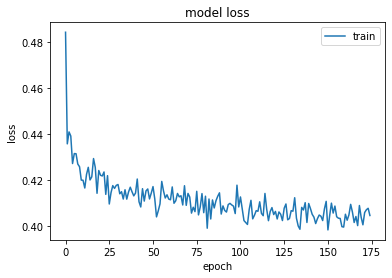

auroc:  0.7164783721365708
f1:  0.4327301337529504
threshold:  0.15927842
precision:  0.32816229116945106
recall:  0.6351039260969977
accuracy:  0.6841874726237407
specificity:  0.6956756756756757
CPU times: user 7min 58s, sys: 1min 7s, total: 9min 5s
Wall time: 2min 29s


In [42]:
%%time
### A single run w/out cross-validation
# with previous outcome added to the features
# outcome is added before scaling
seed(1)
set_random_seed(2)
model = build_model(32, 0.5, max_timestamps, n_features)
fit_model(model, 175, X_train_pad, y_train_pad, verbose=1)
y_predict = model.predict(X_test_pad)
y_test_len = [len(y) for y in y_test_list]
y_predict = truncate_prediction(y_predict, y_test_len)
y_true = np.concatenate(y_test_list)
print('auroc: ', auroc(y_predict, y_true))
f1, th = find_best_f1(y_predict, y_true)
print('f1: ', f1);
print('threshold: ', th)
precision, recall, accuracy, specificity = other_metrics(y_predict, y_true, th)
print('precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accuracy)
print('specificity: ', specificity)

Epoch 1/225
1755/1755 [==============================] - 1s 749us/step - loss: 0.4789 - binary_accuracy: 0.8141
Epoch 2/225
1755/1755 [==============================] - 1s 396us/step - loss: 0.4507 - binary_accuracy: 0.8200
Epoch 3/225
1755/1755 [==============================] - 1s 400us/step - loss: 0.4379 - binary_accuracy: 0.8220
Epoch 4/225
1755/1755 [==============================] - 1s 401us/step - loss: 0.4345 - binary_accuracy: 0.8157
Epoch 5/225
1755/1755 [==============================] - 1s 404us/step - loss: 0.4314 - binary_accuracy: 0.8214
Epoch 6/225
1755/1755 [==============================] - 1s 402us/step - loss: 0.4274 - binary_accuracy: 0.8204
Epoch 7/225
1755/1755 [==============================] - 1s 400us/step - loss: 0.4290 - binary_accuracy: 0.8239
Epoch 8/225
1755/1755 [==============================] - 1s 396us/step - loss: 0.4310 - binary_accuracy: 0.8206
Epoch 9/225
1755/1755 [==============================] - 1s 398us/step - loss: 0.4264 - binary_accuracy:

1755/1755 [==============================] - 1s 400us/step - loss: 0.4086 - binary_accuracy: 0.8297
Epoch 74/225
1755/1755 [==============================] - 1s 397us/step - loss: 0.4107 - binary_accuracy: 0.8293
Epoch 75/225
1755/1755 [==============================] - 1s 399us/step - loss: 0.4126 - binary_accuracy: 0.8254
Epoch 76/225
1755/1755 [==============================] - 1s 391us/step - loss: 0.4059 - binary_accuracy: 0.8291
Epoch 77/225
1755/1755 [==============================] - 1s 396us/step - loss: 0.4166 - binary_accuracy: 0.8290
Epoch 78/225
1755/1755 [==============================] - 1s 407us/step - loss: 0.4047 - binary_accuracy: 0.8313
Epoch 79/225
1755/1755 [==============================] - 1s 403us/step - loss: 0.4072 - binary_accuracy: 0.8287
Epoch 80/225
1755/1755 [==============================] - 1s 403us/step - loss: 0.4007 - binary_accuracy: 0.8345
Epoch 81/225
1755/1755 [==============================] - 1s 404us/step - loss: 0.4026 - binary_accuracy: 0.8

1755/1755 [==============================] - 1s 394us/step - loss: 0.4020 - binary_accuracy: 0.8305
Epoch 146/225
1755/1755 [==============================] - 1s 396us/step - loss: 0.4027 - binary_accuracy: 0.8309
Epoch 147/225
1755/1755 [==============================] - 1s 416us/step - loss: 0.3949 - binary_accuracy: 0.8335
Epoch 148/225
1755/1755 [==============================] - 1s 426us/step - loss: 0.4043 - binary_accuracy: 0.8276
Epoch 149/225
1755/1755 [==============================] - 1s 420us/step - loss: 0.3977 - binary_accuracy: 0.8341
Epoch 150/225
1755/1755 [==============================] - 1s 402us/step - loss: 0.3984 - binary_accuracy: 0.8371
Epoch 151/225
1755/1755 [==============================] - 1s 412us/step - loss: 0.4017 - binary_accuracy: 0.8314
Epoch 152/225
1755/1755 [==============================] - 1s 401us/step - loss: 0.3996 - binary_accuracy: 0.8344
Epoch 153/225
1755/1755 [==============================] - 1s 402us/step - loss: 0.3959 - binary_accur

Epoch 217/225
1755/1755 [==============================] - 1s 393us/step - loss: 0.3965 - binary_accuracy: 0.8362
Epoch 218/225
1755/1755 [==============================] - 1s 396us/step - loss: 0.3917 - binary_accuracy: 0.8400
Epoch 219/225
1755/1755 [==============================] - 1s 393us/step - loss: 0.3972 - binary_accuracy: 0.8334
Epoch 220/225
1755/1755 [==============================] - 1s 401us/step - loss: 0.3908 - binary_accuracy: 0.8348
Epoch 221/225
1755/1755 [==============================] - 1s 398us/step - loss: 0.3969 - binary_accuracy: 0.8328
Epoch 222/225
1755/1755 [==============================] - 1s 398us/step - loss: 0.3938 - binary_accuracy: 0.8356
Epoch 223/225
1755/1755 [==============================] - 1s 399us/step - loss: 0.3943 - binary_accuracy: 0.8345
Epoch 224/225
1755/1755 [==============================] - 1s 408us/step - loss: 0.4040 - binary_accuracy: 0.8302
Epoch 225/225
1755/1755 [==============================] - 1s 411us/step - loss: 0.3945 

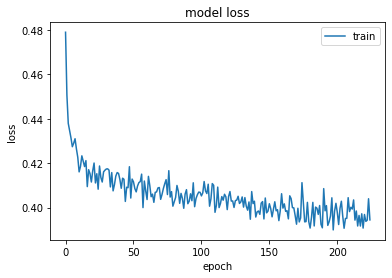

Epoch 1/225
1755/1755 [==============================] - 1s 785us/step - loss: 0.4800 - binary_accuracy: 0.8135
Epoch 2/225
1755/1755 [==============================] - 1s 397us/step - loss: 0.4498 - binary_accuracy: 0.8210
Epoch 3/225
1755/1755 [==============================] - 1s 394us/step - loss: 0.4319 - binary_accuracy: 0.8196
Epoch 4/225
1755/1755 [==============================] - 1s 399us/step - loss: 0.4342 - binary_accuracy: 0.8227
Epoch 5/225
1755/1755 [==============================] - 1s 396us/step - loss: 0.4244 - binary_accuracy: 0.8264
Epoch 6/225
1755/1755 [==============================] - 1s 394us/step - loss: 0.4272 - binary_accuracy: 0.8187
Epoch 7/225
1755/1755 [==============================] - 1s 399us/step - loss: 0.4305 - binary_accuracy: 0.8215
Epoch 8/225
1755/1755 [==============================] - 1s 402us/step - loss: 0.4308 - binary_accuracy: 0.8224
Epoch 9/225
1755/1755 [==============================] - 1s 400us/step - loss: 0.4247 - binary_accuracy:

1755/1755 [==============================] - 1s 398us/step - loss: 0.4085 - binary_accuracy: 0.8289
Epoch 74/225
1755/1755 [==============================] - 1s 400us/step - loss: 0.4032 - binary_accuracy: 0.8350
Epoch 75/225
1755/1755 [==============================] - 1s 400us/step - loss: 0.4063 - binary_accuracy: 0.8312
Epoch 76/225
1755/1755 [==============================] - 1s 398us/step - loss: 0.4094 - binary_accuracy: 0.8311
Epoch 77/225
1755/1755 [==============================] - 1s 394us/step - loss: 0.4003 - binary_accuracy: 0.8300
Epoch 78/225
1755/1755 [==============================] - 1s 395us/step - loss: 0.4110 - binary_accuracy: 0.8300
Epoch 79/225
1755/1755 [==============================] - 1s 399us/step - loss: 0.4034 - binary_accuracy: 0.8338
Epoch 80/225
1755/1755 [==============================] - 1s 440us/step - loss: 0.4033 - binary_accuracy: 0.8361
Epoch 81/225
1755/1755 [==============================] - 1s 408us/step - loss: 0.4046 - binary_accuracy: 0.8

1755/1755 [==============================] - 1s 401us/step - loss: 0.3981 - binary_accuracy: 0.8331
Epoch 146/225
1755/1755 [==============================] - 1s 406us/step - loss: 0.3941 - binary_accuracy: 0.8395
Epoch 147/225
1755/1755 [==============================] - 1s 403us/step - loss: 0.4013 - binary_accuracy: 0.8311
Epoch 148/225
1755/1755 [==============================] - 1s 405us/step - loss: 0.3984 - binary_accuracy: 0.8401
Epoch 149/225
1755/1755 [==============================] - 1s 396us/step - loss: 0.4004 - binary_accuracy: 0.8365
Epoch 150/225
1755/1755 [==============================] - 1s 401us/step - loss: 0.3947 - binary_accuracy: 0.8360
Epoch 151/225
1755/1755 [==============================] - 1s 396us/step - loss: 0.3951 - binary_accuracy: 0.8331
Epoch 152/225
1755/1755 [==============================] - 1s 395us/step - loss: 0.3994 - binary_accuracy: 0.8342
Epoch 153/225
1755/1755 [==============================] - 1s 405us/step - loss: 0.4000 - binary_accur

Epoch 217/225
1755/1755 [==============================] - 1s 407us/step - loss: 0.3940 - binary_accuracy: 0.8337
Epoch 218/225
1755/1755 [==============================] - 1s 397us/step - loss: 0.3969 - binary_accuracy: 0.8373
Epoch 219/225
1755/1755 [==============================] - 1s 395us/step - loss: 0.3966 - binary_accuracy: 0.8373
Epoch 220/225
1755/1755 [==============================] - 1s 409us/step - loss: 0.3935 - binary_accuracy: 0.8348
Epoch 221/225
1755/1755 [==============================] - 1s 399us/step - loss: 0.3911 - binary_accuracy: 0.8377
Epoch 222/225
1755/1755 [==============================] - 1s 401us/step - loss: 0.3931 - binary_accuracy: 0.8372
Epoch 223/225
1755/1755 [==============================] - 1s 397us/step - loss: 0.3951 - binary_accuracy: 0.8363
Epoch 224/225
1755/1755 [==============================] - 1s 396us/step - loss: 0.3914 - binary_accuracy: 0.8372
Epoch 225/225
1755/1755 [==============================] - 1s 400us/step - loss: 0.3874 

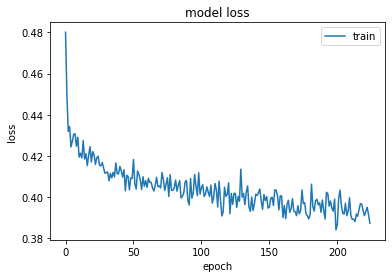

Epoch 1/225
1754/1754 [==============================] - 1s 842us/step - loss: 0.4740 - binary_accuracy: 0.8179
Epoch 2/225
1754/1754 [==============================] - 1s 417us/step - loss: 0.4382 - binary_accuracy: 0.8274
Epoch 3/225
1754/1754 [==============================] - 1s 437us/step - loss: 0.4355 - binary_accuracy: 0.8261
Epoch 4/225
1754/1754 [==============================] - 1s 399us/step - loss: 0.4349 - binary_accuracy: 0.8261
Epoch 5/225
1754/1754 [==============================] - 1s 403us/step - loss: 0.4297 - binary_accuracy: 0.8206
Epoch 6/225
1754/1754 [==============================] - 1s 400us/step - loss: 0.4258 - binary_accuracy: 0.8258
Epoch 7/225
1754/1754 [==============================] - 1s 400us/step - loss: 0.4193 - binary_accuracy: 0.8256
Epoch 8/225
1754/1754 [==============================] - 1s 397us/step - loss: 0.4208 - binary_accuracy: 0.8264
Epoch 9/225
1754/1754 [==============================] - 1s 400us/step - loss: 0.4211 - binary_accuracy:

1754/1754 [==============================] - 1s 394us/step - loss: 0.4014 - binary_accuracy: 0.8330
Epoch 74/225
1754/1754 [==============================] - 1s 395us/step - loss: 0.4008 - binary_accuracy: 0.8339
Epoch 75/225
1754/1754 [==============================] - 1s 396us/step - loss: 0.4027 - binary_accuracy: 0.8327
Epoch 76/225
1754/1754 [==============================] - 1s 397us/step - loss: 0.3960 - binary_accuracy: 0.8414
Epoch 77/225
1754/1754 [==============================] - 1s 395us/step - loss: 0.3980 - binary_accuracy: 0.8380
Epoch 78/225
1754/1754 [==============================] - 1s 405us/step - loss: 0.4072 - binary_accuracy: 0.8257
Epoch 79/225
1754/1754 [==============================] - 1s 438us/step - loss: 0.3957 - binary_accuracy: 0.8337
Epoch 80/225
1754/1754 [==============================] - 1s 396us/step - loss: 0.4008 - binary_accuracy: 0.8297
Epoch 81/225
1754/1754 [==============================] - 1s 397us/step - loss: 0.3961 - binary_accuracy: 0.8

1754/1754 [==============================] - 1s 398us/step - loss: 0.3884 - binary_accuracy: 0.8344
Epoch 146/225
1754/1754 [==============================] - 1s 402us/step - loss: 0.3976 - binary_accuracy: 0.8346
Epoch 147/225
1754/1754 [==============================] - 1s 399us/step - loss: 0.4022 - binary_accuracy: 0.8378
Epoch 148/225
1754/1754 [==============================] - 1s 403us/step - loss: 0.3975 - binary_accuracy: 0.8341
Epoch 149/225
1754/1754 [==============================] - 1s 399us/step - loss: 0.3956 - binary_accuracy: 0.8318
Epoch 150/225
1754/1754 [==============================] - 1s 397us/step - loss: 0.3990 - binary_accuracy: 0.8327
Epoch 151/225
1754/1754 [==============================] - 1s 406us/step - loss: 0.3954 - binary_accuracy: 0.8313
Epoch 152/225
1754/1754 [==============================] - 1s 396us/step - loss: 0.3927 - binary_accuracy: 0.8310
Epoch 153/225
1754/1754 [==============================] - 1s 404us/step - loss: 0.3909 - binary_accur

Epoch 217/225
1754/1754 [==============================] - 1s 401us/step - loss: 0.3835 - binary_accuracy: 0.8394
Epoch 218/225
1754/1754 [==============================] - 1s 403us/step - loss: 0.3894 - binary_accuracy: 0.8336
Epoch 219/225
1754/1754 [==============================] - 1s 395us/step - loss: 0.3858 - binary_accuracy: 0.8408
Epoch 220/225
1754/1754 [==============================] - 1s 395us/step - loss: 0.3882 - binary_accuracy: 0.8393
Epoch 221/225
1754/1754 [==============================] - 1s 401us/step - loss: 0.3808 - binary_accuracy: 0.8423
Epoch 222/225
1754/1754 [==============================] - 1s 398us/step - loss: 0.3870 - binary_accuracy: 0.8390
Epoch 223/225
1754/1754 [==============================] - 1s 398us/step - loss: 0.3932 - binary_accuracy: 0.8345
Epoch 224/225
1754/1754 [==============================] - 1s 398us/step - loss: 0.3938 - binary_accuracy: 0.8316
Epoch 225/225
1754/1754 [==============================] - 1s 395us/step - loss: 0.3934 

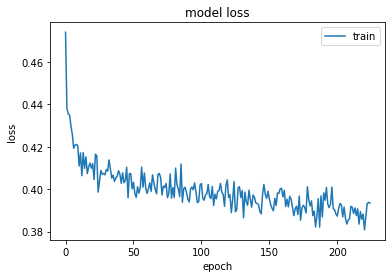

Epoch 1/225
1754/1754 [==============================] - 2s 893us/step - loss: 0.4855 - binary_accuracy: 0.8146
Epoch 2/225
1754/1754 [==============================] - 1s 405us/step - loss: 0.4503 - binary_accuracy: 0.8192
Epoch 3/225
1754/1754 [==============================] - 1s 402us/step - loss: 0.4438 - binary_accuracy: 0.8159
Epoch 4/225
1754/1754 [==============================] - 1s 398us/step - loss: 0.4364 - binary_accuracy: 0.8231
Epoch 5/225
1754/1754 [==============================] - 1s 402us/step - loss: 0.4419 - binary_accuracy: 0.8207
Epoch 6/225
1754/1754 [==============================] - 1s 394us/step - loss: 0.4325 - binary_accuracy: 0.8229
Epoch 7/225
1754/1754 [==============================] - 1s 401us/step - loss: 0.4376 - binary_accuracy: 0.8212
Epoch 8/225
1754/1754 [==============================] - 1s 404us/step - loss: 0.4217 - binary_accuracy: 0.8260
Epoch 9/225
1754/1754 [==============================] - 1s 395us/step - loss: 0.4283 - binary_accuracy:

1754/1754 [==============================] - 1s 397us/step - loss: 0.4169 - binary_accuracy: 0.8264
Epoch 74/225
1754/1754 [==============================] - 1s 402us/step - loss: 0.4098 - binary_accuracy: 0.8264
Epoch 75/225
1754/1754 [==============================] - 1s 399us/step - loss: 0.4038 - binary_accuracy: 0.8289
Epoch 76/225
1754/1754 [==============================] - 1s 408us/step - loss: 0.4128 - binary_accuracy: 0.8276
Epoch 77/225
1754/1754 [==============================] - 1s 389us/step - loss: 0.4118 - binary_accuracy: 0.8298
Epoch 78/225
1754/1754 [==============================] - 1s 396us/step - loss: 0.4035 - binary_accuracy: 0.8278
Epoch 79/225
1754/1754 [==============================] - 1s 394us/step - loss: 0.4108 - binary_accuracy: 0.8251
Epoch 80/225
1754/1754 [==============================] - 1s 394us/step - loss: 0.4088 - binary_accuracy: 0.8294
Epoch 81/225
1754/1754 [==============================] - 1s 398us/step - loss: 0.4102 - binary_accuracy: 0.8

1754/1754 [==============================] - 1s 402us/step - loss: 0.3973 - binary_accuracy: 0.8302
Epoch 146/225
1754/1754 [==============================] - 1s 393us/step - loss: 0.3978 - binary_accuracy: 0.8387
Epoch 147/225
1754/1754 [==============================] - 1s 391us/step - loss: 0.3995 - binary_accuracy: 0.8327
Epoch 148/225
1754/1754 [==============================] - 1s 399us/step - loss: 0.4008 - binary_accuracy: 0.8305
Epoch 149/225
1754/1754 [==============================] - 1s 394us/step - loss: 0.4004 - binary_accuracy: 0.8336
Epoch 150/225
1754/1754 [==============================] - 1s 396us/step - loss: 0.3947 - binary_accuracy: 0.8362
Epoch 151/225
1754/1754 [==============================] - 1s 400us/step - loss: 0.4038 - binary_accuracy: 0.8277
Epoch 152/225
1754/1754 [==============================] - 1s 395us/step - loss: 0.4054 - binary_accuracy: 0.8306
Epoch 153/225
1754/1754 [==============================] - 1s 395us/step - loss: 0.3988 - binary_accur

Epoch 217/225
1754/1754 [==============================] - 1s 401us/step - loss: 0.4025 - binary_accuracy: 0.8312
Epoch 218/225
1754/1754 [==============================] - 1s 397us/step - loss: 0.4017 - binary_accuracy: 0.8325
Epoch 219/225
1754/1754 [==============================] - 1s 398us/step - loss: 0.4009 - binary_accuracy: 0.8265
Epoch 220/225
1754/1754 [==============================] - 1s 396us/step - loss: 0.3956 - binary_accuracy: 0.8356
Epoch 221/225
1754/1754 [==============================] - 1s 392us/step - loss: 0.3970 - binary_accuracy: 0.8299
Epoch 222/225
1754/1754 [==============================] - 1s 390us/step - loss: 0.3966 - binary_accuracy: 0.8317
Epoch 223/225
1754/1754 [==============================] - 1s 400us/step - loss: 0.3944 - binary_accuracy: 0.8316
Epoch 224/225
1754/1754 [==============================] - 1s 389us/step - loss: 0.3997 - binary_accuracy: 0.8294
Epoch 225/225
1754/1754 [==============================] - 1s 397us/step - loss: 0.4041 

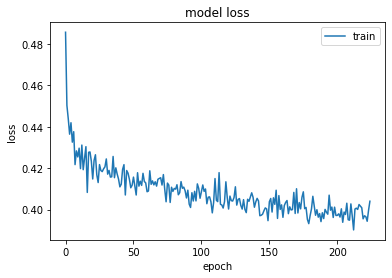

Epoch 1/225
1754/1754 [==============================] - 2s 919us/step - loss: 0.4897 - binary_accuracy: 0.8085
Epoch 2/225
1754/1754 [==============================] - 1s 396us/step - loss: 0.4486 - binary_accuracy: 0.8184
Epoch 3/225
1754/1754 [==============================] - 1s 394us/step - loss: 0.4440 - binary_accuracy: 0.8187
Epoch 4/225
1754/1754 [==============================] - 1s 396us/step - loss: 0.4393 - binary_accuracy: 0.8203
Epoch 5/225
1754/1754 [==============================] - 1s 390us/step - loss: 0.4235 - binary_accuracy: 0.8249
Epoch 6/225
1754/1754 [==============================] - 1s 393us/step - loss: 0.4318 - binary_accuracy: 0.8195
Epoch 7/225
1754/1754 [==============================] - 1s 393us/step - loss: 0.4249 - binary_accuracy: 0.8226
Epoch 8/225
1754/1754 [==============================] - 1s 399us/step - loss: 0.4297 - binary_accuracy: 0.8197
Epoch 9/225
1754/1754 [==============================] - 1s 421us/step - loss: 0.4349 - binary_accuracy:

1754/1754 [==============================] - 1s 394us/step - loss: 0.4079 - binary_accuracy: 0.8275
Epoch 74/225
1754/1754 [==============================] - 1s 398us/step - loss: 0.4133 - binary_accuracy: 0.8258
Epoch 75/225
1754/1754 [==============================] - 1s 397us/step - loss: 0.4099 - binary_accuracy: 0.8269
Epoch 76/225
1754/1754 [==============================] - 1s 393us/step - loss: 0.4105 - binary_accuracy: 0.8221
Epoch 77/225
1754/1754 [==============================] - 1s 396us/step - loss: 0.4084 - binary_accuracy: 0.8265
Epoch 78/225
1754/1754 [==============================] - 1s 395us/step - loss: 0.4024 - binary_accuracy: 0.8343
Epoch 79/225
1754/1754 [==============================] - 1s 395us/step - loss: 0.4109 - binary_accuracy: 0.8295
Epoch 80/225
1754/1754 [==============================] - 1s 399us/step - loss: 0.4060 - binary_accuracy: 0.8292
Epoch 81/225
1754/1754 [==============================] - 1s 394us/step - loss: 0.4078 - binary_accuracy: 0.8

1754/1754 [==============================] - 1s 401us/step - loss: 0.4035 - binary_accuracy: 0.8315
Epoch 146/225
1754/1754 [==============================] - 1s 412us/step - loss: 0.3980 - binary_accuracy: 0.8330
Epoch 147/225
1754/1754 [==============================] - 1s 402us/step - loss: 0.3997 - binary_accuracy: 0.8281
Epoch 148/225
1754/1754 [==============================] - 1s 402us/step - loss: 0.4000 - binary_accuracy: 0.8292
Epoch 149/225
1754/1754 [==============================] - 1s 395us/step - loss: 0.4055 - binary_accuracy: 0.8295
Epoch 150/225
1754/1754 [==============================] - 1s 404us/step - loss: 0.4006 - binary_accuracy: 0.8351
Epoch 151/225
1754/1754 [==============================] - 1s 405us/step - loss: 0.4024 - binary_accuracy: 0.8315
Epoch 152/225
1754/1754 [==============================] - 1s 403us/step - loss: 0.4044 - binary_accuracy: 0.8290
Epoch 153/225
1754/1754 [==============================] - 1s 398us/step - loss: 0.4006 - binary_accur

Epoch 217/225
1754/1754 [==============================] - 1s 405us/step - loss: 0.3903 - binary_accuracy: 0.8375
Epoch 218/225
1754/1754 [==============================] - 1s 404us/step - loss: 0.3969 - binary_accuracy: 0.8308
Epoch 219/225
1754/1754 [==============================] - 1s 402us/step - loss: 0.3909 - binary_accuracy: 0.8382
Epoch 220/225
1754/1754 [==============================] - 1s 399us/step - loss: 0.3954 - binary_accuracy: 0.8316
Epoch 221/225
1754/1754 [==============================] - 1s 395us/step - loss: 0.3941 - binary_accuracy: 0.8342
Epoch 222/225
1754/1754 [==============================] - 1s 389us/step - loss: 0.3953 - binary_accuracy: 0.8300
Epoch 223/225
1754/1754 [==============================] - 1s 388us/step - loss: 0.3911 - binary_accuracy: 0.8382
Epoch 224/225
1754/1754 [==============================] - 1s 389us/step - loss: 0.3952 - binary_accuracy: 0.8368
Epoch 225/225
1754/1754 [==============================] - 1s 401us/step - loss: 0.3930 

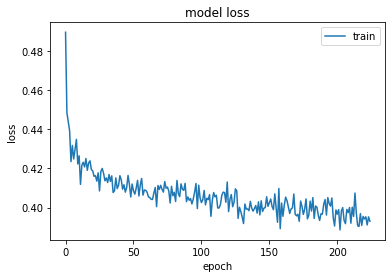

In [43]:
## Run 5-fold cross-validation to get average performance characteristics
unit = 32
ratio = 0.5
epoch = 225
(auroc_list, other_metric_list) = kfold_validation(unit, ratio, epoch, X_train_transformed, y_train, 'patient-id', \
                                                   n_features=n_features, verbose=1)

In [44]:
## other_metric_list has precision, recall, accuracy, specificity, f1, threshold for metrics
ave_prec = np.mean([x[0] for x in other_metric_list])
print("average precision:" + str(ave_prec))

ave_recall = np.mean([x[1] for x in other_metric_list])
print("average recall:" + str(ave_recall))

ave_specificity = np.mean([x[3] for x in other_metric_list])
print("average specificity:" + str(ave_specificity))

ave_f1 = np.mean([x[4] for x in other_metric_list])
print("average F1:" + str(ave_f1))

average precision:0.3507831646105487
average recall:0.5914853241664627
average specificity:0.755527543395597
average F1:0.43823327416139934


In [45]:
max_f1 = np.max([x[4] for x in other_metric_list])
print("max F1: " + str(max_f1))

max F1: 0.45875251509054327


In [46]:
## Average metrics performance
print("unit: %d\tepoch: %d\tauroc_mean: %f\tauroc_std: %f"  % (unit, epoch, np.mean(auroc_list), np.std(auroc_list)))

unit: 32	epoch: 225	auroc_mean: 0.723179	auroc_std: 0.012437
